In [1]:
#import modules
import numpy as np
import pandas as pd
import time
from keras import backend as K 
from keras.engine.training import Model
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
#import data
df = pd.read_csv('../Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
#define train and label column
train_cols = ["Precipitation","Temperature","Outflow"]
label_cols = ["Outflow(t+1)"]

In [4]:
#filter the columns
new_df = df.filter(train_cols, axis=1)

In [5]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

#getting data ready for training the model
def data_processing(lag_df):
    #Splitting training and test data
    df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
    x_train = df_train.loc[:,train_cols].values
    y_train = df_train.loc[:,label_cols].values
    x_test = df_test.loc[:,train_cols].values
    y_test = df_test.loc[:,label_cols].values    
   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
    y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label
    y_train_actual = y_train
    y_test_actual = y_test
    
    return x_train_nor, y_train_nor, y_train_actual, x_test_nor, y_test_nor, y_test_actual

In [7]:
#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

In [8]:
#Building timeseries
x_train_nor, y_train_nor, y_train_actual, x_test_nor, y_test_nor, y_test_actual = data_processing(lag_df)
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



length of time-series i/o (148416, 18, 3) (148416,)



length of time-series i/o (37091, 18, 3) (37091,)


In [9]:
#Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    lstm1 = LSTM(units=16, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.2)(lstm1)
    lstm2 = LSTM(units=32, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)
    lstm3 = LSTM(units=64)(dropout2)
    dropout3 = Dropout(0.2)(lstm3)

    dense1 = Dense(128, activation='relu')(dropout3)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)


In [10]:
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []

def run_iteration(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model = make_model(X_Train)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Train, Y_Train, epochs=epochs,
                       validation_data=(X_Test, Y_Test))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
               
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values, predicted_y_values_unnor, model

predicted_y_values, predicted_y_values_unnor, model = run_iteration(1,10)

Iteration: 1
Epoch 1/10
4638/4638 [==============================] - 60s 13ms/step - loss: 1.3665e-04 - val_loss: 9.5106e-05
Epoch 2/10
4638/4638 [==============================] - 73s 16ms/step - loss: 5.2869e-05 - val_loss: 3.2244e-05
Epoch 3/10
4638/4638 [==============================] - 82s 18ms/step - loss: 4.1892e-05 - val_loss: 1.5722e-04
Epoch 4/10
4638/4638 [==============================] - 80s 17ms/step - loss: 3.5962e-05 - val_loss: 2.0481e-05
Epoch 5/10
4638/4638 [==============================] - 76s 16ms/step - loss: 2.6742e-05 - val_loss: 7.4602e-05
Epoch 6/10
4638/4638 [==============================] - 79s 17ms/step - loss: 2.8924e-05 - val_loss: 1.7974e-05
Epoch 7/10
4638/4638 [==============================] - 78s 17ms/step - loss: 2.4621e-05 - val_loss: 1.2770e-05
Epoch 8/10
4638/4638 [==============================] - 81s 17ms/step - loss: 2.2133e-05 - val_loss: 2.7484e-05
Epoch 9/10
4638/4638 [==============================] - 73s 16ms/step - loss: 2.2675e-05 - 

In [11]:
#prediction for X_Train values which has to be used to predict another day output
y_train_predict = model.predict(X_Train)

In [12]:
#for model2
#Building timeseries
X_Train1, Y_Train1, Y_train_actual1 = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=19, out_steps=1)
X_Test1, Y_Test1, Y_test_actual1 = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=19, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



length of time-series i/o (148415, 19, 3) (148415,)



length of time-series i/o (37090, 19, 3) (37090,)


In [13]:
#replacing last value of each timeseries data with the predicted value
len_data = len(X_Train1)
for i in range (len_data):
    X_Train1[i][18][2] = y_train_predict[i][0]
len_data_test = len(X_Test1)
for i in range (len_data_test):
    X_Test1[i][18][2] = predicted_y_values[i][0]

In [14]:
mse_for_iter1 = []
train_loss_over_epoch1 = []
val_loss_over_epoch1 = []
predicted_y_values1_unnors = []
models = []

def run_iteration_model_2(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model1 = make_model(X_Train1)
        #plot_model(model, show_shapes=True)
        model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model1.fit(X_Train1, Y_Train1, epochs=epochs,
                       validation_data=(X_Test1, Y_Test1))
        train_loss_over_epoch1.append(history.history['loss'])
        val_loss_over_epoch1.append(history.history['val_loss'])
        predicted_y_values1 = model1.predict(X_Test1)
        predicted_y_values1_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values1)
        mse_for_iter1.append(mean_squared_error(predicted_y_values1_unnor, Y_test_actual1))
        predicted_y_values1_unnors.append(predicted_y_values1_unnor)
        models.append(model1)
               
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values1, predicted_y_values1_unnor, model1

predicted_y_values1, predicted_y_values1_unnor, model1 = run_iteration_model_2(20,10)

Iteration: 1
Epoch 1/10
4638/4638 [==============================] - 118s 26ms/step - loss: 1.6441e-04 - val_loss: 7.3106e-05
Epoch 2/10
4638/4638 [==============================] - 106s 23ms/step - loss: 7.2694e-05 - val_loss: 4.8472e-05
Epoch 3/10
4638/4638 [==============================] - 108s 23ms/step - loss: 5.3962e-05 - val_loss: 4.9655e-05
Epoch 4/10
4638/4638 [==============================] - 116s 25ms/step - loss: 4.4520e-05 - val_loss: 4.2064e-05
Epoch 5/10
4638/4638 [==============================] - 99s 21ms/step - loss: 3.7278e-05 - val_loss: 4.1803e-05
Epoch 6/10
4638/4638 [==============================] - 85s 18ms/step - loss: 3.4295e-05 - val_loss: 2.9837e-05
Epoch 7/10
4638/4638 [==============================] - 85s 18ms/step - loss: 3.2741e-05 - val_loss: 1.1843e-04
Epoch 8/10
4638/4638 [==============================] - 85s 18ms/step - loss: 3.2770e-05 - val_loss: 6.3373e-05
Epoch 9/10
4638/4638 [==============================] - 85s 18ms/step - loss: 2.8717e-0

4638/4638 [==============================] - 81s 17ms/step - loss: 3.8312e-05 - val_loss: 3.9966e-05
Epoch 6/10
4638/4638 [==============================] - 81s 18ms/step - loss: 3.4055e-05 - val_loss: 4.8090e-05
Epoch 7/10
4638/4638 [==============================] - 81s 18ms/step - loss: 3.0324e-05 - val_loss: 2.7165e-05
Epoch 8/10
4638/4638 [==============================] - 82s 18ms/step - loss: 3.0141e-05 - val_loss: 2.8398e-05
Epoch 9/10
4638/4638 [==============================] - 81s 18ms/step - loss: 2.8181e-05 - val_loss: 3.0593e-05
Epoch 10/10
4638/4638 [==============================] - 82s 18ms/step - loss: 2.6986e-05 - val_loss: 2.2499e-05
Iteration: 16
Epoch 1/10
4638/4638 [==============================] - 83s 18ms/step - loss: 1.5861e-04 - val_loss: 1.0529e-04
Epoch 2/10
4638/4638 [==============================] - 82s 18ms/step - loss: 6.7006e-05 - val_loss: 4.9431e-05
Epoch 3/10
4638/4638 [==============================] - 82s 18ms/step - loss: 4.6799e-05 - val_loss:

In [15]:
model.save("lstm_model2_3_features.hdf5")

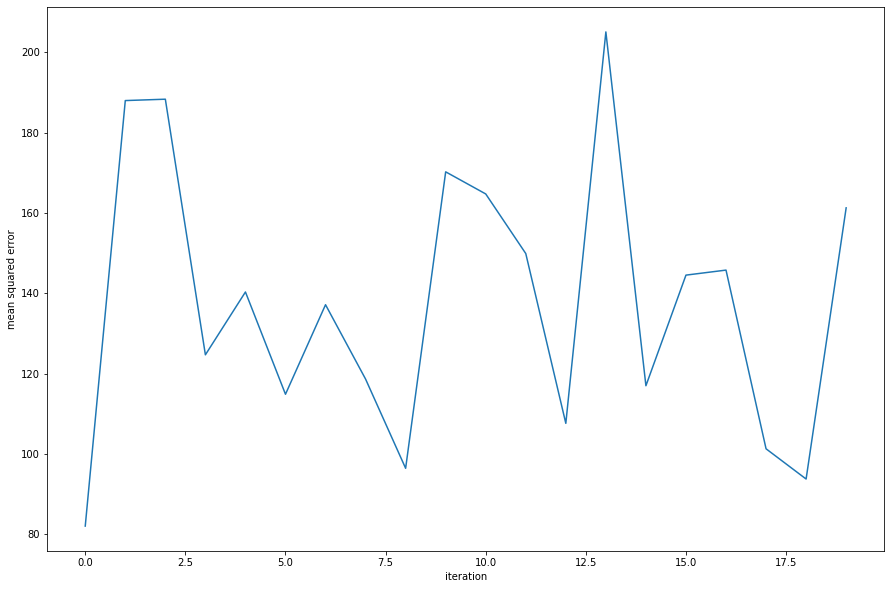

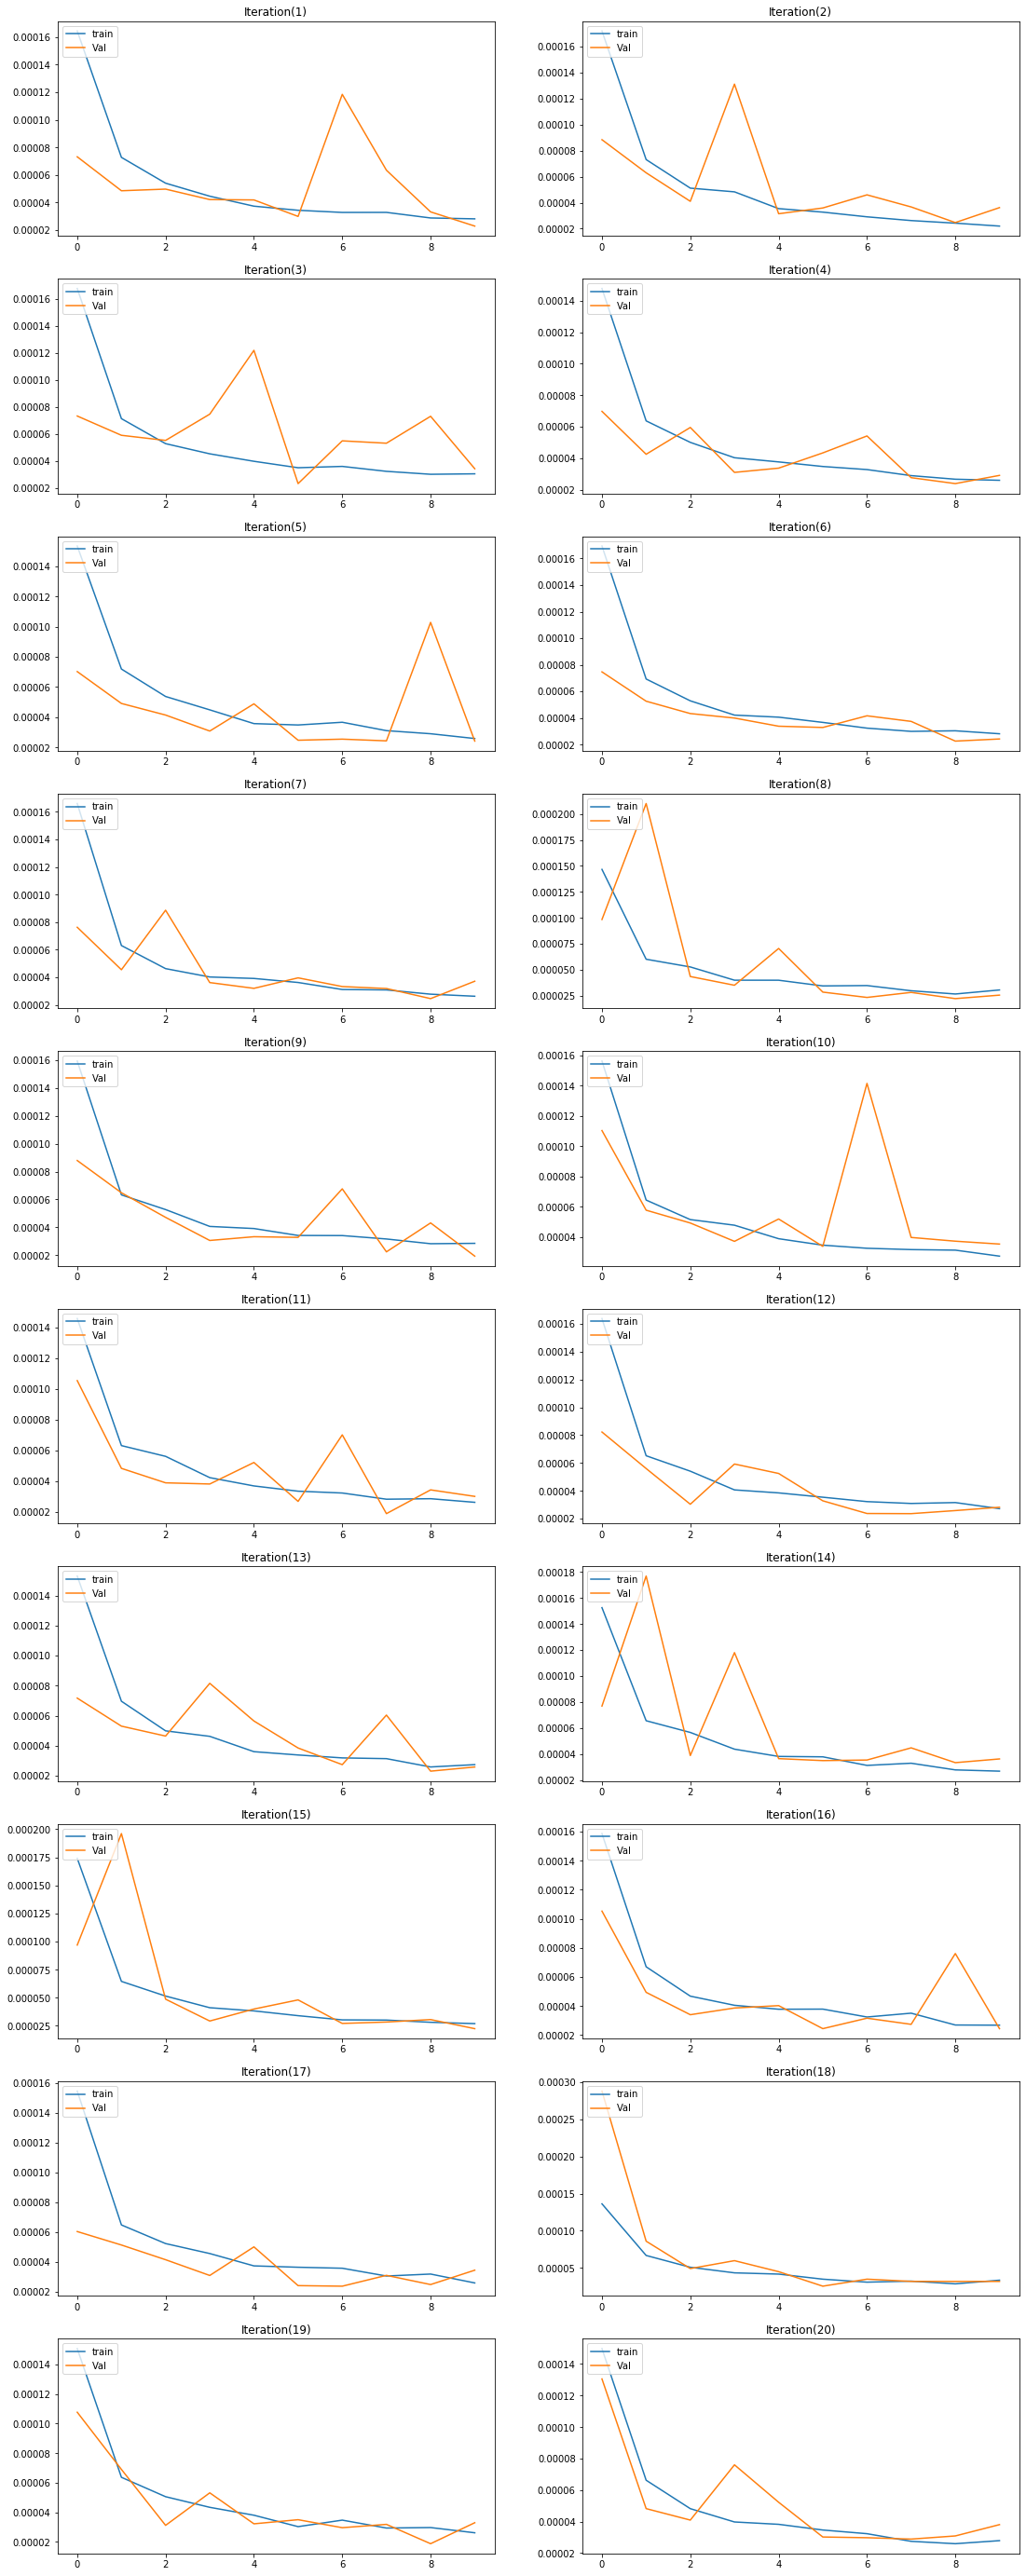

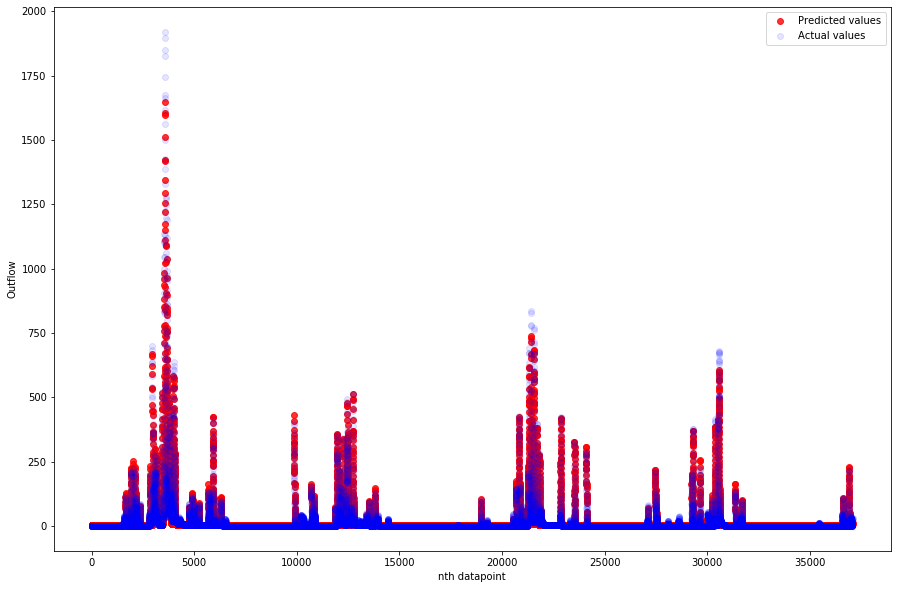

In [16]:
def plot_evaluation():
    #mean square error over iterations
    plt.figure(figsize=(15, 10))
    plt.plot(mse_for_iter1)
    plt.ylabel('mean squared error')
    plt.xlabel('iteration')
    plt.savefig('mse.png', bbox_inches='tight')
    plt.show()
        
    #plot train and validation loss over epochs for each iteration
    fig, axs = plt.subplots(10, 2)
    #axs.set_ylabel('loss')
    #axs.set_xlabel('epoch')
    fig.set_size_inches(18.5, 50)
    for row in range(10):
        for col in range(2):
            index = 2*row + col #index to get loss from training loss and validation loss list
            axs[row, col].plot(train_loss_over_epoch1[index])
            axs[row, col].plot(val_loss_over_epoch1[index])
            axs[row, col].set_title('Iteration(%d)' %(index+1))
            axs[row, col].legend(['train', 'Val'], loc='upper left')            
    plt.savefig('train_val_loss.png', bbox_inches='tight')
    
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values1_unnor, 'ro', alpha=0.8)
    plt.plot(Y_test_actual1, 'bo', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('nth datapoint')
    plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [17]:
mse_for_iter1

[82.0375677058987,
 188.00882092435742,
 188.3514523116305,
 124.69297962479718,
 140.33943341080573,
 114.87155676280663,
 137.16694875100734,
 118.6457832770747,
 96.42899052944514,
 170.26004434884817,
 164.75484059965663,
 149.90998723489346,
 107.62505559265242,
 205.10910403306974,
 116.9906356353942,
 144.5396145865188,
 145.78971643306267,
 101.28584007747824,
 93.75804245313432,
 161.29150702537962]

In [18]:
print(np.mean(mse_for_iter1))

137.59289606589556


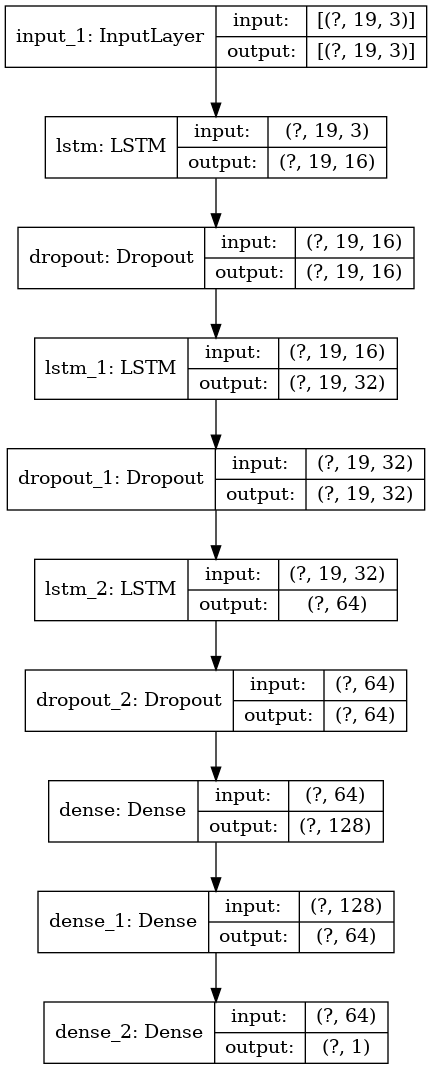

In [19]:
plot_model(model1, show_shapes=True)